# 데이터 전처리 성능 비교

## data1

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor
from xgboost import XGBClassifier

from scipy.stats import boxcox
from scipy.special import boxcox1p

import tensorflow.keras as keras
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

In [1]:
def data1_prepro(df1=None, train=False, onehot=True):
    '''
    data1 전처리 함수.

    args:
        train : 학습용으로 전처리할것인지
        onehot : 원핫인코딩 할것인지 타겟인코딩 할것인지 (False=타겟인코딩)
    
    returns:
        X_train, X_test, y_train, y_test : train=True인경우
        X : train=False인 경우
    '''
    if not df1:
        df1 = pd.read_csv('data/Regression_data.csv')

    num_cols = df1.drop(columns=['Sex', 'Rings']).columns
    cat_cols = ['Sex']

    # Height 이상치 클립 : 최대값 0.3
    df1.Height.clip(upper=0.3, inplace=True)

    # ohe 인경우 먼저 인코딩
    scaler = StandardScaler()
    scaler.set_output(transform='pandas')
    ohe = OneHotEncoder(sparse_output=False)
    ohe.set_output(transform='pandas')
    te = TargetEncoder(target_type='continuous')
    te.set_output(transform='pandas')

    # 컬럼 변환기1 : Sex ohe, 나머지 표준화
    data1_ct_ohe = make_column_transformer(
        (ohe, cat_cols),
        (scaler, num_cols),
        remainder='passthrough'
    )
    data1_ct_ohe.set_output(transform='pandas')

    # 컬럼 변환기2 : Sex te, 나머지 표준화
    data1_ct_te = make_column_transformer(
        (te, cat_cols),
        (scaler, num_cols),
        remainder='passthrough'
    )
    data1_ct_te.set_output(transform='pandas')

    if 'Rings' in df1:
        X = df1.drop(columns='Rings')   
        y = df1.Rings
    else:
        X = df1

    if train:
        # test비율 20%로
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.2,
                                                            random_state=42)
        if onehot:
            X_train = data1_ct_ohe.fit_transform(X_train)
            X_test = data1_ct_ohe.transform(X_test)
        else:
            X_train = data1_ct_te.fit_transform(X_train, y_train)
            X_test = data1_ct_te.transform(X_test)
        return X_train, X_test, y_train, y_test
    else:
        return X
    

X_train, X_test, y_train, y_test = data1_prepro(train=True)
X_train_te, X_test_te, y_train_te, y_test_te = data1_prepro(train=True, onehot=False)

model = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model2 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose=False)

model2.fit(X_train_te, y_train_te,
          eval_set=[(X_test_te, y_test_te)],
          verbose=False)
''

''

In [2]:
# AE로 차원축소

def AE_feature_extraction(X):
    """
    오토인코더로 차원축소 7 => 4
    학습후에 인코더만 반환
    """
    # 7 => 4
    encoder = keras.models.Sequential([
        keras.layers.Dense(4, activation='relu')
        ]
    )
    # 4 => 7
    decoder = keras.models.Sequential([
        keras.layers.Dense(7, activation=None)
        ]
    )
    # 컴파일 : loss = mse, opt = adam
    AutoEncoder = keras.Sequential([encoder, decoder])
    AutoEncoder.compile(optimizer=keras.optimizers.Adam(0.01),
                        loss='mse')
    
    # 콜백 정의
    # reduce_lr : 학습이 잘 안되면(6 epochs) 학습률 감소
    # e_stop : 특정epoch이상 차도 없으면(12 epochs) 중단
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.5, patience=6,
                                                     verbose=0, mode='auto')
    e_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=12,
                                              restore_best_weights=True)
    # 학습
    hist = AutoEncoder.fit(X, X,
                           batch_size=32,
                           validation_split=.25,
                           epochs=200,
                           callbacks=[e_stop, reduce_lr],
                           verbose=0)
    
    # 오토인코더 train, val의 epoch별 loss확인
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='val')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    return encoder

encoder = AE_feature_extraction(X_train.iloc[:,3:])

In [21]:
X_train2 = np.hstack((X_train.iloc[:,:3], encoder.predict(X_train.iloc[:,3:], verbose=0)))
X_test2 = np.hstack((X_test.iloc[:,:3], encoder.predict(X_test.iloc[:,3:], verbose=0)))

model3 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model3.fit(X_train2, y_train,
           eval_set=[(X_test2, y_test)],
           verbose=False)
''

''

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)

X_train3 = pca.fit_transform(X_train.iloc[:,3:])
X_test3 = pca.transform(X_test.iloc[:,3:])

X_train3 = np.hstack((X_train.iloc[:,:3], X_train3))
X_test3 = np.hstack((X_test.iloc[:,:3], X_test3))

model4 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model4.fit(X_train3, y_train,
           eval_set=[(X_test3, y_test)],
           verbose=False)
''

''

In [131]:
# 혹시 모르니 skewness 조정된 버전도 실험

def data1_prepro_noskew(df1=None):

    if not df1:
        df1 = pd.read_csv('data/Regression_data.csv')

    num_cols = df1.drop(columns=['Sex', 'Rings']).columns
    cat_cols = ['Sex']

    # Height 이상치 클립 : 최대값 0.3
    df1.Height.clip(upper=0.3, inplace=True)

    # boxcox로 Sex, Ring제외 skewness 전부 조정
    temp = df1[num_cols].apply(lambda x: x+0.001).apply(lambda x: boxcox(x)[0])
    X = pd.concat([df1[cat_cols], temp], axis=1)
    y = df1.Rings

    # ohe 인경우 먼저 인코딩
    scaler = StandardScaler()
    scaler.set_output(transform='pandas')
    ohe = OneHotEncoder(sparse_output=False)
    ohe.set_output(transform='pandas')

    # 컬럼 변환기1 : Sex ohe, 나머지 표준화
    data1_ct_ohe = make_column_transformer(
        (ohe, cat_cols),
        (scaler, num_cols),
        remainder='passthrough'
    )
    data1_ct_ohe.set_output(transform='pandas')
    
    # test비율 20%로
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=40)
    
    X_train = data1_ct_ohe.fit_transform(X_train)
    X_test = data1_ct_ohe.transform(X_test)

    return X_train, X_test, y_train, y_test

X_train4, X_test4, y_train4, y_test4 = data1_prepro_noskew()

model5 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model5.fit(X_train4, y_train4,
           eval_set=[(X_test4, y_test4)],
           verbose=False)
''

''

In [143]:
def cv(model, X_train, X_test, y_train, y_test):
    rmse =cross_val_score(model, X_train, y_train,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          fit_params={'eval_set':[(X_test, y_test)],
                                      'verbose':False,})

    rmse = np.sqrt(np.abs(rmse))
    return rmse

ohe_rmse = cv(model, X_train, X_test, y_train, y_test)
ohe_noskew_rmse = cv(model5, X_train4, X_test4, y_train4, y_test4)
te_rmse = cv(model2, X_train_te, X_test_te, y_train_te, y_test_te)
ae_rmse = cv(model3, X_train2, X_test2, y_train, y_test)
pca_rmse = cv(model4, X_train3, X_test3, y_train, y_test)

print(f'ohe cv rmse : {ohe_rmse}')
print(f'ohe cv noskew rmse : {ohe_noskew_rmse}')
print(f'te cv rmse : {te_rmse}')
print(f'ae cv rmse : {ae_rmse}')
print(f'pca cv rmse : {pca_rmse}\n')

print(f'ohe mean rmse : {np.mean(ohe_rmse)}')
print(f'ohe noskew mean rmse : {np.mean(ohe_noskew_rmse)}')
print(f'te mean rmse : {np.mean(te_rmse)}')
print(f'ae mean rmse : {np.mean(ae_rmse)}')
print(f'pca mean rmse : {np.mean(pca_rmse)}')

# xgboost가 공선성에 강하므로 AE, PCA를 통한 feature extraction은 큰 의미는 없는것 같다.
# 마찬가지로 skewness를 없애고 진행해도 결과차이는 크지 않다.


ohe cv rmse : [2.0640369  2.29157908 2.29728733 2.17979154 2.00275552]
ohe cv noskew rmse : [2.19021825 2.2022373  2.21177252 2.15222797 2.219526  ]
te cv rmse : [2.07481908 2.31469053 2.29444519 2.16152719 2.05606906]
ae cv rmse : [2.16315881 2.44069981 2.43922467 2.28064144 2.11798293]
pca cv rmse : [2.13613558 2.42536024 2.32408536 2.27655981 2.10901572]

ohe mean rmse : 2.167090074629537
ohe noskew mean rmse : 2.1951964094506162
te mean rmse : 2.1803102090912247
ae mean rmse : 2.288341532186832
pca mean rmse : 2.2542313412077624


In [15]:
# 신경망도 사용해보기
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.cache().shuffle(3500).batch(32)
valid_ds = valid_ds.cache().shuffle(1000).batch(32)

l1 = tf.keras.regularizers.l1(1e-4)

nn = keras.models.Sequential([
    keras.layers.Dense(64, input_shape=[10,],
                       kernel_regularizer=l1),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(32, kernel_regularizer=l1),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(16, kernel_regularizer=l1),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(8, kernel_regularizer=l1),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(1),
])

nn.compile(optimizer=keras.optimizers.Adam(0.01),
           loss='mse')

# 콜백 정의
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.5, patience=6,
                                                     verbose=0, mode='auto')
e_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=12,
                                            restore_best_weights=True)

# hist = nn.fit(train_ds,
#               validation_data=valid_ds,
#               epochs=200,
#               callbacks=[reduce_lr, e_stop],
#               verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

NameError: name 'hist' is not defined

In [34]:
print(f'nn rmse : {np.sqrt(nn.evaluate(X_test, y_test, verbose=0)):.3f}')

# 아무래도 신경망이다보니 튜닝안된 xgboost보단 성능이 좋은편

nn rmse : 2.122


## data1 전처리 요약
* Height 이상치 처리
* Sex 원핫인코딩, 혹은 타겟인코딩
* 수치형 변수 skewness조정시도
* 수치형 변수들 표준화
* 두가지 차원축소 방법 채택 (AE, PCA)
---
결과
* ohe, te, ae, pca 쓴 결과들이 전부 비슷하다.  
* skewness조정한것과 안한것의 차이거의없다.

    => 전처리에서 더 할게 있나??

## data2

In [224]:
df2 = pd.read_csv('data/binary_classification_data.csv')

# row 갯수 비교적 많음
# 상관계수는 별문제 없음. 2개세트만 좀 큰듯?
# 클래스불균형 심함 (0:~91%, 1:~9%)
#   * 레거시코드에선 target_class 1 단순 오버샘플링만 한듯?
# 이상치 있는 컬럼 3개
# 바이올린플롯 확인결과 아웃라이어 밴드중에 1이 많은 경우가 좀 있다.
#   => 일단 이상치 제거 없이 진행

X = df2.drop(columns='target_class')
y = df2.target_class
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=.25,
                                                    stratify=y,
                                                    random_state=42)

# 표준화
scaler = StandardScaler()
scaler.set_output(transform='pandas')

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.cache().shuffle(14000).batch(32)
valid_ds = valid_ds.cache().shuffle(5000).batch(32)

In [246]:
b_model1 = XGBClassifier(objective='binary:logistic',
                         n_estimators=1000,
                         learning_rate=0.05,
                         max_depth=10,
                         early_stopping_rounds=20,
                         colsample_bytree=0.7,
                         eval_metric='aucpr',
                         scale_pos_weight=10,
                         reg_lambda=5,
                         tree_method='gpu_hist',
                         gpu_id=0,
                         random_state=41)


b_model1.fit(X_train, y_train,
             eval_set=[(X_test, y_test)],
             verbose=10)

print(classification_report(y_test, b_model1.predict(X_test),digits=4))
# 기본결과

[0]	validation_0-aucpr:0.84769


[10]	validation_0-aucpr:0.92113
[20]	validation_0-aucpr:0.92184
[30]	validation_0-aucpr:0.92364
[40]	validation_0-aucpr:0.92552
[50]	validation_0-aucpr:0.92399
[60]	validation_0-aucpr:0.93050
[70]	validation_0-aucpr:0.93066
[80]	validation_0-aucpr:0.93083
[90]	validation_0-aucpr:0.93107
[100]	validation_0-aucpr:0.93097
[110]	validation_0-aucpr:0.93068
[111]	validation_0-aucpr:0.93062
              precision    recall  f1-score   support

           0     0.9899    0.9857    0.9878      4065
           1     0.8642    0.9000    0.8817       410

    accuracy                         0.9779      4475
   macro avg     0.9270    0.9429    0.9348      4475
weighted avg     0.9784    0.9779    0.9781      4475



In [226]:
X2 = X.apply(np.log)
print(X2.skew())
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y,
                                                        test_size=.25,
                                                        stratify=y,
                                                        random_state=42)


b_model2 = XGBClassifier(objective='binary:logistic',
                         n_estimators=1000,
                         learning_rate=0.05,
                         max_depth=10,
                         early_stopping_rounds=20,
                         colsample_bytree=0.7,
                         eval_metric='aucpr',
                         scale_pos_weight=10,
                         reg_lambda=5,
                         tree_method='gpu_hist',
                         gpu_id=0,
                         random_state=41)


b_model2.fit(X_train2, y_train2,
             eval_set=[(X_test2, y_test2)],
             verbose=100)

print(classification_report(y_test2, b_model2.predict(X_test2),digits=4))
# 로그변환으로 왜도를 낮춰도 성능에 별 변화가 없다. (약간 하락)

 Mean of the integrated profile                 -3.555214
 Standard deviation of the integrated profile   -0.533652
 Excess kurtosis of the integrated profile      -0.402860
 Skewness of the integrated profile              0.011625
 Mean of the DM-SNR curve                        1.378879
 Standard deviation of the DM-SNR curve          0.959045
 Excess kurtosis of the DM-SNR curve            -2.835663
 Skewness of the DM-SNR curve                   -1.834078
dtype: float64
[0]	validation_0-aucpr:0.85358


[100]	validation_0-aucpr:0.92907
[117]	validation_0-aucpr:0.92888
              precision    recall  f1-score   support

           0     0.9891    0.9847    0.9869      4065
           1     0.8551    0.8927    0.8735       410

    accuracy                         0.9763      4475
   macro avg     0.9221    0.9387    0.9302      4475
weighted avg     0.9769    0.9763    0.9765      4475



In [124]:
# 랜덤포레스트성능도 확인
from sklearn.ensemble import RandomForestClassifier

b_model3 = RandomForestClassifier(n_estimators=300,
                              criterion='entropy',
                              max_depth=9,
                              n_jobs=-1,
                              random_state=42)

b_model3.fit(X_train, y_train)
print(classification_report(y_test, b_model3.predict(X_test), digits=4))
# 랜덤포레스트도 성능은 별차이 없다.

              precision    recall  f1-score   support

           0     0.9849    0.9931    0.9890      4065
           1     0.9255    0.8488    0.8855       410

    accuracy                         0.9799      4475
   macro avg     0.9552    0.9209    0.9372      4475
weighted avg     0.9794    0.9799    0.9795      4475



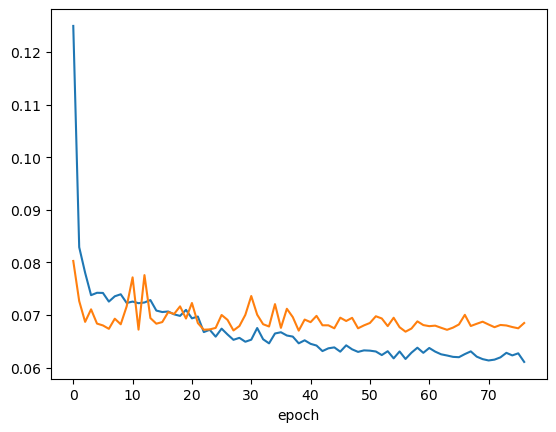

In [10]:
# 업샘플링 시도: SMOTE, ADASYN
# 모델은 앞으로 신경망을 쓰는걸로 결정


# 우선 기본모델부터
b_model4 = tf.keras.Sequential([
    keras.layers.Dense(64, input_shape=[8,]),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(32),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(8),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(1, activation='sigmoid')
])
b_model4.compile(loss='binary_crossentropy',
                 metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                 optimizer=keras.optimizers.Adam(0.01))

# 콜백 재정의
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5, patience=10,
                                                 verbose=0, mode='auto')
e_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=20,
                                          restore_best_weights=False)
hist = b_model4.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.show()

In [11]:
def prec_recall(model, X_test, y_test):
    precision, recall, th = precision_recall_curve(y_test, model.predict(X_test, verbose=False),
                                                   pos_label=1)
    
    f1 = 2 * (precision * recall) / (precision + recall)
    best = np.argmax(f1)
    return precision[best], recall[best], f1[best], th[best]


_, recall, f1, th = prec_recall(b_model4, X_test, y_test)

print(f'recall : {recall:.3f}\nf1 : {f1:.3f}\nth : {th:.3f}')

recall : 0.878
f1 : 0.887
th : 0.399


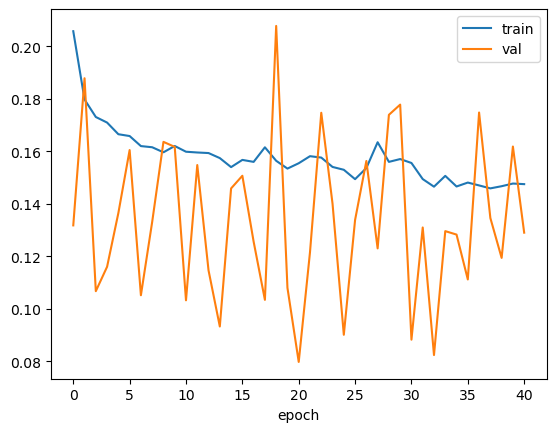

In [8]:
# SMOTE 
from imblearn.over_sampling import SMOTE

X_train2, y_train2 = SMOTE(random_state=42, k_neighbors=5).fit_resample(X_train, y_train)
train_ds2 = tf.data.Dataset.from_tensor_slices((X_train2, y_train2))
train_ds2 = train_ds2.cache().shuffle(28000).batch(32)


b_model5 = keras.models.clone_model(b_model4)
b_model5.compile(loss='binary_crossentropy',
                 metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                 optimizer=keras.optimizers.Adam(0.1))

e_stop.monitor = 'val_loss'
reduce_lr.monitor = 'val_loss'

hist = b_model5.fit(train_ds2,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.show()

In [9]:
_, recall, f1, th = prec_recall(b_model5, X_test, y_test)
print(f'recall : {recall:.3f}\nf1 : {f1:.3f}\nth : {th:.3f}')
# SMOTE 돌릴때마다 결과가 다르다. 사실상 기본과 큰차이 없는듯?

recall : 0.861
f1 : 0.887
th : 0.854


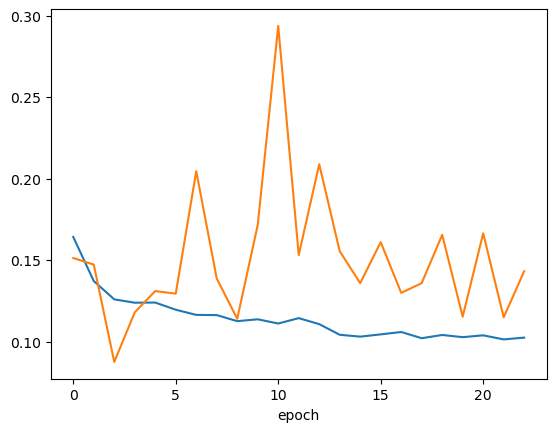

In [30]:
# SMOTEENN

X_train3, y_train3 = SMOTEENN().fit_resample(X_train, y_train)
train_ds3 = tf.data.Dataset.from_tensor_slices((X_train3, y_train3))
train_ds3 = train_ds3.cache().shuffle(28000).batch(32)

b_model6 = keras.models.clone_model(b_model4)
b_model6.compile(loss='binary_crossentropy',
                 metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                 optimizer=keras.optimizers.Adam(0.1))

e_stop.monitor = 'val_loss'
reduce_lr.monitor = 'val_loss'

hist = b_model6.fit(train_ds3,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.show()

In [31]:
_, recall, f1, th = prec_recall(b_model6, X_test, y_test)
print(f'recall : {recall:.3f}\nf1 : {f1:.3f}\nth : {th:.3f}')
# SMOTEENN도 f1살짝 증가. 리콜은 비슷

recall : 0.871
f1 : 0.894
th : 0.618


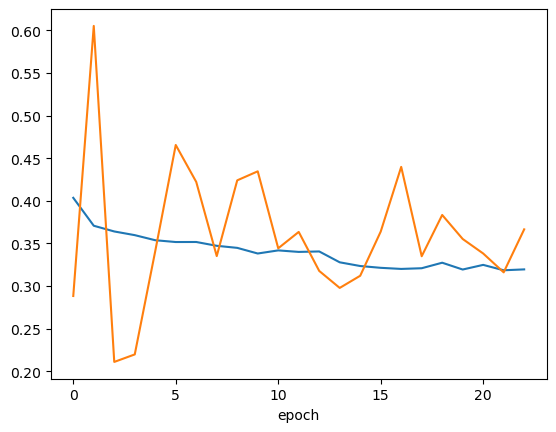

In [34]:
# ADASYN
from imblearn.over_sampling import ADASYN

X_train5, y_train5 = ADASYN(n_neighbors=5).fit_resample(X_train, y_train)
train_ds4 = tf.data.Dataset.from_tensor_slices((X_train5, y_train5))
train_ds4 = train_ds4.cache().shuffle(28000).batch(32)

b_model7 = keras.models.clone_model(b_model4)
b_model7.compile(loss='binary_crossentropy',
                 metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                 optimizer=keras.optimizers.Adam(0.1))

e_stop.monitor = 'val_loss'
reduce_lr.monitor = 'val_loss'

hist = b_model7.fit(train_ds4,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.show()

In [35]:
_, recall, f1, th = prec_recall(b_model7, X_test, y_test)
print(f'recall : {recall:.3f}\nf1 : {f1:.3f}\nth : {th:.3f}')
# ADASYN역시 f1살짝증가 . 리콜은 감소.
# n_neighbors를 늘리면 : f1비슷. 리콜감소..

recall : 0.841
f1 : 0.893
th : 0.930


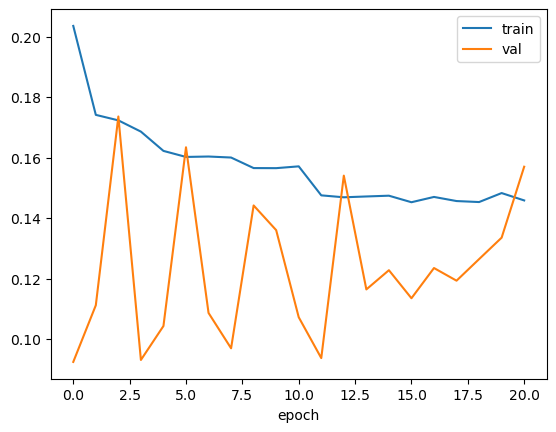

In [15]:
# SMOTETomek : SMOTE와 더불어 소수 클래스와 인접한 다수클래스 삭제
# => 결정경계를 명확히 구분시키는 효과가 있다.
from imblearn.combine import SMOTETomek

X_train6, y_train6 = SMOTETomek().fit_resample(X_train, y_train)
train_ds5 = tf.data.Dataset.from_tensor_slices((X_train6, y_train6))
train_ds5 = train_ds5.cache().shuffle(28000).batch(32)

b_model8 = keras.models.clone_model(b_model4)
b_model8.compile(loss='binary_crossentropy',
                 metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                 optimizer=keras.optimizers.Adam(0.1))

e_stop.monitor = 'val_loss'
reduce_lr.monitor = 'val_loss'

hist = b_model8.fit(train_ds5,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.show()

In [16]:
_, recall, f1, th = prec_recall(b_model8, X_test, y_test)
print(f'recall : {recall:.3f}\nf1 : {f1:.3f}\nth : {th:.3f}')
# SMOTETomek : f1비슷, 리콜 크게감소. 고려할 이유 없는듯

recall : 0.846
f1 : 0.889
th : 0.954


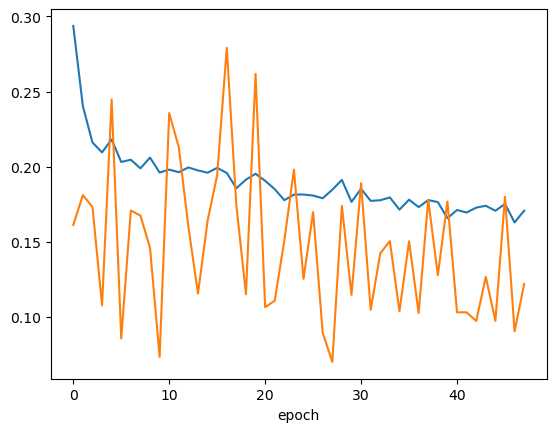

In [20]:
# 오버샘플링 없이 가중치만 설정해서 교육
weight0 = (1 / y_train.value_counts()[0]) * (y_train.shape[0] / 2.0)
weight1 = (1 / y_train.value_counts()[1]) * (y_train.shape[0] / 2.0)
c_weight = {0:weight0, 1:weight1}

b_model9 = keras.models.clone_model(b_model4)
b_model9.compile(loss='binary_crossentropy',
                 metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                 optimizer=keras.optimizers.Adam(0.1))

e_stop.monitor = 'val_loss'
reduce_lr.monitor = 'val_loss'

hist = b_model9.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    class_weight=c_weight,
                    verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.show()

In [22]:
_, recall, f1, th = prec_recall(b_model9, X_test, y_test)
print(f'recall : {recall:.3f}\nf1 : {f1:.3f}\nth : {th:.3f}')
# class_weight조정 : 리콜감소, f1 비슷.. 

recall : 0.846
f1 : 0.889
th : 0.846


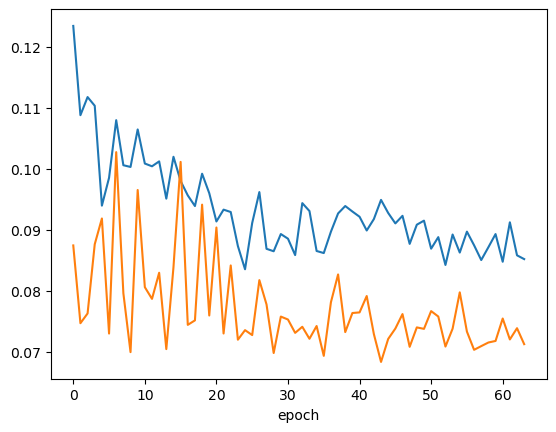

In [27]:
# 코스트 센시티브 학습
def weighted_bce(y_true, y_pred):
    bce = keras.losses.BinaryCrossentropy()
    loss = bce(y_true, y_pred)
    weight_vector = tf.where(y_true == 1, 5.461, 0.550)
    loss = loss * weight_vector
    return tf.reduce_mean(loss)

b_model10 = keras.models.clone_model(b_model4)
b_model10.compile(loss=weighted_bce,
                 metrics='accuracy',
                 optimizer=keras.optimizers.Adam(0.1))

e_stop.monitor = 'val_loss'
reduce_lr.monitor = 'val_loss'
e_stop.restore_best_weights = True

hist = b_model10.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    class_weight=c_weight,
                    verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.show()

In [33]:
_, recall, f1, th = prec_recall(b_model10, X_test, y_test)
print(f'recall : {recall:.3f}\nf1 : {f1:.3f}\nth : {th:.3f}')
# 코스트 센시티브 : f1 소폭증가, 리콜감소

recall : 0.856
f1 : 0.889
th : 0.534


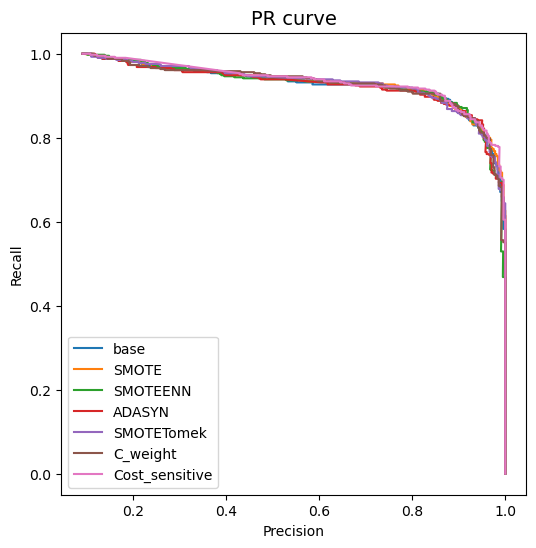

In [47]:
# 각 샘플링기법 AUCPR 생성
models = dict(zip(['base', 'SMOTE', 'SMOTEENN', 'ADASYN', 'SMOTETomek', 'C_weight', 'Cost_sensitive'],
                  [b_model4, b_model5, b_model6, b_model7, b_model8, b_model9, b_model10]))

plt.figure(figsize=(6,6))
for name, model in models.items():
    precision, recall, _ = precision_recall_curve(
        y_test,
        model.predict(X_test, verbose=False),
        pos_label=1
    )
    plt.plot(precision, recall, label=name)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR curve', fontsize=14)
plt.legend()
plt.show()

## data2 전처리 요약
* 오버샘플링 혹은 클래스 가중치 조정에따른 효과가 크지 않다.
* 최대 f1은 살짝 향상되는편이고, 리콜은 분산이 너무 심하다.
* 그나마 f1도 높고 리콜도 안떨어지는게 SMOTEENN
* random_stat 변화에 따라 기본모델 성능이 0.87~0.894까지 다양하다.  
=> SMOTEENN쓰거나, 아니면 아예 안써도 될듯.

## data3

In [213]:
import seaborn as sns

df3 = pd.read_csv('data/mulit_classification_data.csv')

# A300과 A400의 상관계수 1 => A400컬럼 제거 
(df3['TypeOfSteel_A300'] == df3['TypeOfSteel_A400']).any() # => False

target = df3.loc[:,'Pastry':'Other_Faults'].columns
X = df3.drop(columns='TypeOfSteel_A400')
X = X.drop(columns=target, axis=1)
y = df3[target].copy()
y['label'] = np.argmax(y.values, axis=1) # label구분을 위한 컬럼추가

# 범주형 : TypeOfSteel_A300, Outside_Global_Index
cat_cols = ['TypeOfSteel_A300', 'Outside_Global_Index']
num_cols = list(X.drop(columns=cat_cols))

# 범주형 ohe, 나머지 표준화
data3_ct = make_column_transformer(
    (StandardScaler(), num_cols),
    (OneHotEncoder(sparse_output=False, drop='if_binary'), cat_cols),
    remainder='passthrough'
)
data3_ct.set_output(transform='pandas')

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    stratify=y['label'],
                                                    random_state=42)

X_train = data3_ct.fit_transform(X_train)
X_test = data3_ct.transform(X_test)
y_true = y_test.drop('label', axis=1)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train.drop('label', axis=1)))
valid_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test.drop('label', axis=1)))

train_ds = train_ds.cache().shuffle(2000).batch(32)
valid_ds = valid_ds.cache().shuffle(500).batch(32)
# 독립변수 28개, 종속변수 7개

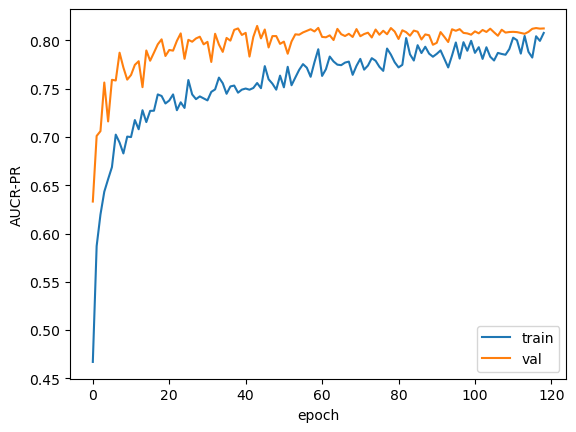

In [219]:
"""
# 조윤서님 작업에서 그래디언트부스팅 모델 최고성능
result:
               precision    recall  f1-score   support

       Bumps       0.77      0.67      0.72        81
   Dirtiness       1.00      0.64      0.78        11
    K_Scatch       0.99      0.97      0.98        78
      Pastry       0.80      0.90      0.85       167
      Stains       1.00      0.93      0.96        14
   Z_Scratch       1.00      0.89      0.94        38

    accuracy                           0.86       389
   macro avg       0.93      0.83      0.87       389
weighted avg       0.87      0.86      0.86       389
"""

# 신경망으로 최고 성능 이상을 달성해야 의미가 있다.

# 콜백 재정의
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5, patience=15,
                                                 verbose=0, mode='auto')
e_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=40,
                                          restore_best_weights=True)


def data3_nn_maker(train_ds, valid_ds, **kwargs):
    m_model = tf.keras.Sequential([
        keras.layers.Dense(16),
        keras.layers.Dropout(0.5),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(32),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(16),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(7, activation='softmax')
    ])
    m_model.compile(loss='categorical_crossentropy',
                    metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                    optimizer=keras.optimizers.Adam(0.01))
    
    hist = m_model.fit(train_ds,
                       validation_data=valid_ds,
                       epochs=200,
                       callbacks=[e_stop, reduce_lr],
                       verbose=0,
                       **kwargs)
    
    plt.plot(hist.history['prc'], label='train')
    plt.plot(hist.history['val_prc'], label='val')
    plt.ylabel('AUCR-PR')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    return m_model

m_model1 = data3_nn_maker(train_ds, valid_ds)

In [220]:
def prediction(m_model):
    pred = m_model.predict(X_test, verbose=False)
    max_val = np.max(pred, axis=1, keepdims=True)
    pred = np.where(pred == max_val, 1, 0)
    return pred


""" 참고 : X_max, y_max 드랍한 성능
                precision    recall  f1-score   support

      Pastry       0.52      0.59      0.55        39
   Z_Scratch       0.75      0.90      0.82        48
    K_Scatch       0.96      0.95      0.95        98
      Stains       0.89      0.94      0.92        18
   Dirtiness       0.70      0.50      0.58        14
       Bumps       0.60      0.72      0.65       101
Other_Faults       0.71      0.58      0.64       168

   micro avg       0.73      0.73      0.73       486
   macro avg       0.73      0.74      0.73       486
weighted avg       0.73      0.73      0.72       486
 samples avg       0.73      0.73      0.73       486
"""
print(classification_report(y_true, prediction(m_model1),
                            target_names=list(y_true)))
# Other_Faults를 포함하고도 꽤 괜찮은 결과가 나왔다.
# 다만 조윤서님 부스팅모델보단 성능이 살짝 떨어지는 모습

              precision    recall  f1-score   support

      Pastry       0.51      0.62      0.56        39
   Z_Scratch       0.78      0.88      0.82        48
    K_Scatch       0.99      0.90      0.94        98
      Stains       0.89      0.94      0.92        18
   Dirtiness       0.62      0.57      0.59        14
       Bumps       0.57      0.69      0.62       101
Other_Faults       0.66      0.55      0.60       168

   micro avg       0.70      0.70      0.70       486
   macro avg       0.72      0.74      0.72       486
weighted avg       0.71      0.70      0.70       486
 samples avg       0.70      0.70      0.70       486



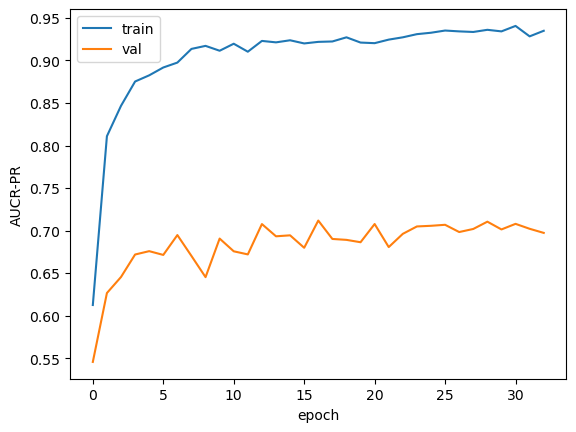

              precision    recall  f1-score   support

      Pastry       0.34      0.77      0.48        39
   Z_Scratch       0.61      0.98      0.75        48
    K_Scatch       0.94      0.95      0.94        98
      Stains       0.94      0.94      0.94        18
   Dirtiness       0.41      0.79      0.54        14
       Bumps       0.62      0.68      0.65       101
Other_Faults       0.84      0.33      0.48       168

   micro avg       0.66      0.66      0.66       486
   macro avg       0.67      0.78      0.68       486
weighted avg       0.74      0.66      0.65       486
 samples avg       0.66      0.66      0.66       486



In [179]:
# SMOTEENN 적용

smote = SMOTE(k_neighbors=7)
enn = EditedNearestNeighbours(n_neighbors=10,
                              sampling_strategy='all',
                              kind_sel='mode')
X_train2, y_train2 = SMOTEENN(smote=smote, enn=enn, random_state=42).fit_resample(X_train, y_train['label'])

# OneHotEncode again
temp = np.zeros((y_train2.shape[0], 7))
for idx, arg in enumerate(y_train2):
    temp[idx, arg] = 1

y_train2 = pd.DataFrame(temp, columns=y_true.columns, index=y_train2.index)

train_ds2 = tf.data.Dataset.from_tensor_slices((X_train2, y_train2))
train_ds2 = train_ds2.cache().shuffle(3000).batch(32)

m_model2 = data3_nn_maker(train_ds2, valid_ds)

print(classification_report(y_true, prediction(m_model2),
                            target_names=list(y_true)))

# SMOTEENN의 파라미터를 여러번 바꿔봐도 성능향상이 없고, 오히려 감소하였다.
# f1 0.05정도 감소. 오버피팅 심함

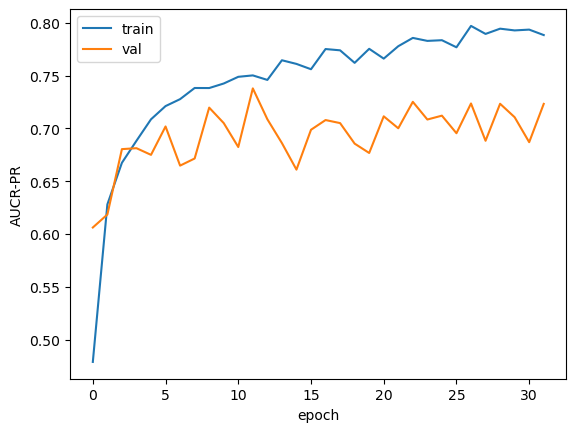

              precision    recall  f1-score   support

      Pastry       0.42      0.77      0.55        39
   Z_Scratch       0.58      0.94      0.72        48
    K_Scatch       0.85      0.98      0.91        98
      Stains       0.81      0.94      0.87        18
   Dirtiness       0.37      0.71      0.49        14
       Bumps       0.55      0.73      0.63       101
Other_Faults       0.88      0.22      0.35       168

   micro avg       0.64      0.64      0.64       486
   macro avg       0.64      0.76      0.64       486
weighted avg       0.72      0.64      0.60       486
 samples avg       0.64      0.64      0.64       486



In [184]:
# ADASYN 적용
X_train3, y_train3 = ADASYN(n_neighbors=3, random_state=42).fit_resample(X_train, y_train['label'])

# OneHotEncode again
temp = np.zeros((y_train3.shape[0], 7))
for idx, arg in enumerate(y_train3):
    temp[idx, arg] = 1

y_train3 = pd.DataFrame(temp, columns=y_true.columns, index=y_train3.index)

train_ds3 = tf.data.Dataset.from_tensor_slices((X_train3, y_train3))
train_ds3 = train_ds3.cache().shuffle(4000).batch(32)

m_model3 = data3_nn_maker(train_ds3, valid_ds)

print(classification_report(y_true, prediction(m_model3),
                            target_names=list(y_true)))
# 마찬가지로 n_neighbors 파라미터 여러번 조정
# => 성능 오히려 떨어졌다. f1 0.05정도

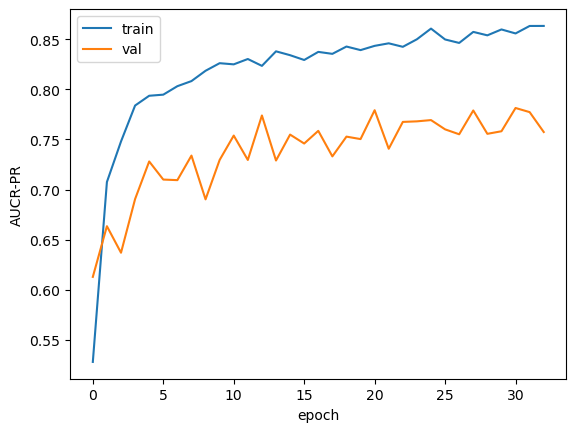

              precision    recall  f1-score   support

      Pastry       0.40      0.82      0.53        39
   Z_Scratch       0.65      0.85      0.74        48
    K_Scatch       0.89      0.95      0.92        98
      Stains       0.85      0.94      0.89        18
   Dirtiness       0.35      0.79      0.49        14
       Bumps       0.59      0.72      0.65       101
Other_Faults       0.78      0.30      0.43       168

   micro avg       0.65      0.65      0.65       486
   macro avg       0.65      0.77      0.67       486
weighted avg       0.71      0.65      0.63       486
 samples avg       0.65      0.65      0.65       486



In [185]:
# SMOTETomek 진행
X_train4, y_train4 = SMOTETomek(random_state=42).fit_resample(X_train, y_train['label'])

# OneHotEncode again
temp = np.zeros((y_train4.shape[0], 7))
for idx, arg in enumerate(y_train4):
    temp[idx, arg] = 1

y_train4 = pd.DataFrame(temp, columns=y_true.columns, index=y_train4.index)

train_ds4 = tf.data.Dataset.from_tensor_slices((X_train4, y_train4))
train_ds4 = train_ds4.cache().shuffle(4000).batch(32)

m_model4 = data3_nn_maker(train_ds4, valid_ds)

print(classification_report(y_true, prediction(m_model4),
                            target_names=list(y_true)))
# 마찬가지로 성능 오히려 떨어짐.. f1 0.05정도

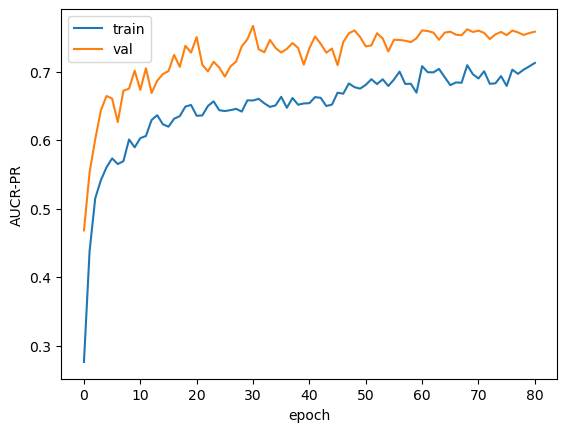

              precision    recall  f1-score   support

      Pastry       0.49      0.74      0.59        39
   Z_Scratch       0.66      0.90      0.76        48
    K_Scatch       0.82      0.96      0.88        98
      Stains       0.74      0.94      0.83        18
   Dirtiness       0.34      0.71      0.47        14
       Bumps       0.60      0.72      0.65       101
Other_Faults       0.78      0.34      0.47       168

   micro avg       0.66      0.66      0.66       486
   macro avg       0.63      0.76      0.67       486
weighted avg       0.70      0.66      0.64       486
 samples avg       0.66      0.66      0.66       486



In [211]:
#Class weight 조정
temp = y_train.label.value_counts().sort_index()
c_weight = {}
for idx, val in enumerate(temp):
    weight = (1 / val) * (y_train.shape[0] / 2.0)
    c_weight[idx] = weight

e_stop.patience = 50
e_stop.restore_best_weights = True
reduce_lr.patience = 15

m_model5 = data3_nn_maker(train_ds, valid_ds, class_weight=c_weight)

print(classification_report(y_true, prediction(m_model5),
                            target_names=list(y_true)))

# f1 0.5정도 감소. 

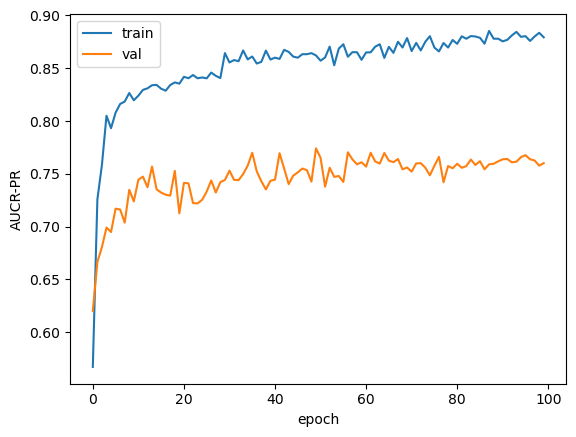

              precision    recall  f1-score   support

      Pastry       0.53      0.67      0.59        39
   Z_Scratch       0.69      0.92      0.79        48
    K_Scatch       0.91      0.95      0.93        98
      Stains       1.00      0.94      0.97        18
   Dirtiness       0.42      0.79      0.55        14
       Bumps       0.51      0.77      0.61       101
Other_Faults       0.75      0.33      0.46       168

   micro avg       0.67      0.67      0.67       486
   macro avg       0.69      0.77      0.70       486
weighted avg       0.71      0.67      0.65       486
 samples avg       0.67      0.67      0.67       486



In [212]:
# 혹시 모르니 SMOTE도 
X_train6, y_train6 = SMOTE(random_state=42).fit_resample(X_train, y_train['label'])

# OneHotEncode again
temp = np.zeros((y_train6.shape[0], 7))
for idx, arg in enumerate(y_train6):
    temp[idx, arg] = 1

y_train6 = pd.DataFrame(temp, columns=y_true.columns, index=y_train6.index)

train_ds6 = tf.data.Dataset.from_tensor_slices((X_train6, y_train6))
train_ds6 = train_ds6.cache().shuffle(4000).batch(32)

e_stop.patience = 50
e_stop.restore_best_weights = True
reduce_lr.patience = 15

m_model6 = data3_nn_maker(train_ds6, valid_ds)

print(classification_report(y_true, prediction(m_model6),
                            target_names=list(y_true)))
# 그나마 SMOTE가 성능이 가장 덜 하락한다.
# 하지만 여전한 오버피팅

## data3 전처리 요약
* 5개 방법 전부 f1이 소폭 감소하였음
* 4개 샘플링 기법들은 전부 오버피팅 발생
* 원인은 아직까지 모르겠다.  
=> 원인 못찾으면 기본 전처리 데이터 가지고 튜닝